# Predicción de Tipos de Cobertura Forestal

## Descripción del Proyecto
Este proyecto analiza el Forest Cover Type Dataset para predecir tipos de cobertura forestal basados en variables cartográficas como elevación, pendiente y tipos de suelo. El objetivo es demostrar habilidades en análisis de datos con enfoque ambiental, útil para empresas verdes o de conservación de biodiversidad.

- **Dataset:** Forest Cover Type de UCI Machine Learning Repository.
- **Fuente:** https://archive.ics.uci.edu/dataset/31/covertype
- **Objetivos:**
  - Realizar EDA para entender distribuciones y correlaciones.
  - Limpiar datos si es necesario (aunque este dataset es limpio).
  - Pruebas de hipótesis: e.g., ¿Hay diferencias significativas en elevación entre tipos de cobertura?
  - Visualizaciones: Histogramas, boxplots, mapas de calor.
  - Modelado: Clasificación multi-clase con Random Forest.
  - Evaluación: Métricas como accuracy, F1-score.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy import stats

# Configuraciones visuales
%matplotlib inline
sns.set(style="whitegrid")

In [22]:
columns = [
    'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
] + [f'Wilderness_Area_{i}' for i in range(1, 5)] + [f'Soil_Type_{i}' for i in range(1, 41)] + ['Cover_Type']

# Carga el dataset (ajusta la ruta)
df = pd.read_csv('D:\Portafolio\Proyecto_Prediccion_cobertura_forestal\covtype.data', header=None, names=columns)

# Muestra las primeras filas
print("Forma del dataset:", df.shape)
df.head()

<>:9: SyntaxWarning: invalid escape sequence '\P'
<>:9: SyntaxWarning: invalid escape sequence '\P'
C:\Users\adria\AppData\Local\Temp\ipykernel_19096\3406527869.py:9: SyntaxWarning: invalid escape sequence '\P'
  df = pd.read_csv('D:\Portafolio\Proyecto_Prediccion_cobertura_forestal\covtype.data', header=None, names=columns)


Forma del dataset: (581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


## Carga y Vista Inicial del Dataset
El dataset contiene 581,012 instancias con 54 features:
- 10 variables cuantitativas (e.g., Elevation, Slope).
- 4 variables binarias para áreas silvestres.
- 40 variables binarias para tipos de suelo.
- Target: Cover_Type (1-7, clases de cobertura forestal).

No hay valores faltantes reportados, pero verificaremos.

In [24]:
# Info general
df.info()

# Estadísticos descriptivos
df.describe()

# Verificar valores faltantes
print("Valores faltantes:\n", df.isnull().sum())

# Distribución del target
print("Distribución de Cover_Type:\n", df['Cover_Type'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area_1                   581012 non-null  int64
 11  Wilderness_Area_2                   581012 non-null 

## Análisis Exploratorio de Datos (EDA)
Exploramos el dataset para entender sus características:
- Distribución del target (`Cover_Type`, clases 1-7), con clases 1 (36.46%) y 2 (48.76%) representando ~85% de los datos, indicando desbalance.
- Distribución de variables cuantitativas (e.g., Elevation, Slope).
- Relaciones entre variables y el target mediante boxplots.
- Correlaciones entre variables cuantitativas (e.g., Hillshade_9am y Hillshade_3pm con r=-0.78) para identificar redundancias.
- Objetivo: Identificar patrones y variables clave para la predicción.

In [26]:
# Definir variables cuantitativas
quantitative_cols = [
    'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
]

print("Variables cuantitativas definidas:", quantitative_cols)

Variables cuantitativas definidas: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']


<Figure size 1500x1000 with 0 Axes>

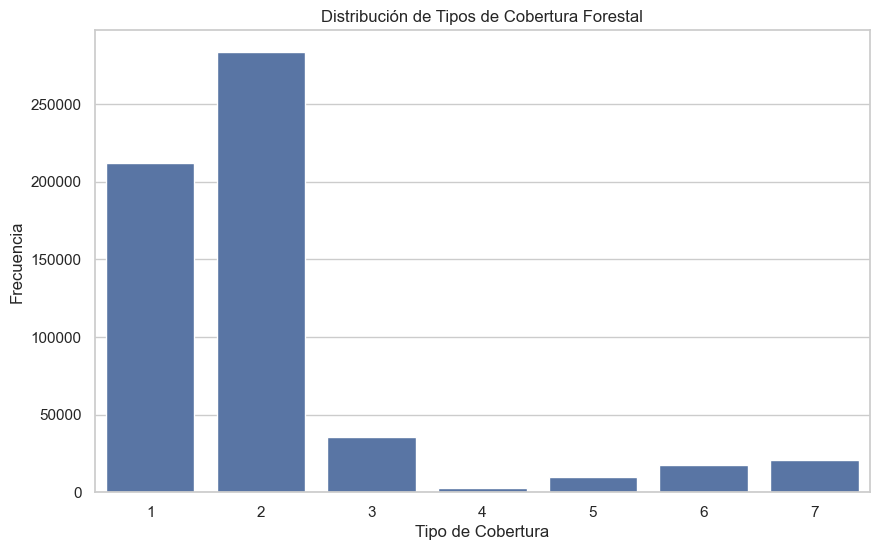

Porcentajes por clase de Cover_Type:
 Cover_Type
2    48.759922
1    36.460521
3     6.153746
7     3.530048
6     2.989095
5     1.633873
4     0.472796
Name: proportion, dtype: float64


In [28]:
# Gráfico de barras para Cover_Type
plt.figure(figsize=(10, 6))
sns.countplot(x='Cover_Type', data=df)
plt.title('Distribución de Tipos de Cobertura Forestal')
plt.xlabel('Tipo de Cobertura')
plt.ylabel('Frecuencia')
plt.show()

# Porcentajes por clase
print("Porcentajes por clase de Cover_Type:\n", df['Cover_Type'].value_counts(normalize=True) * 100)

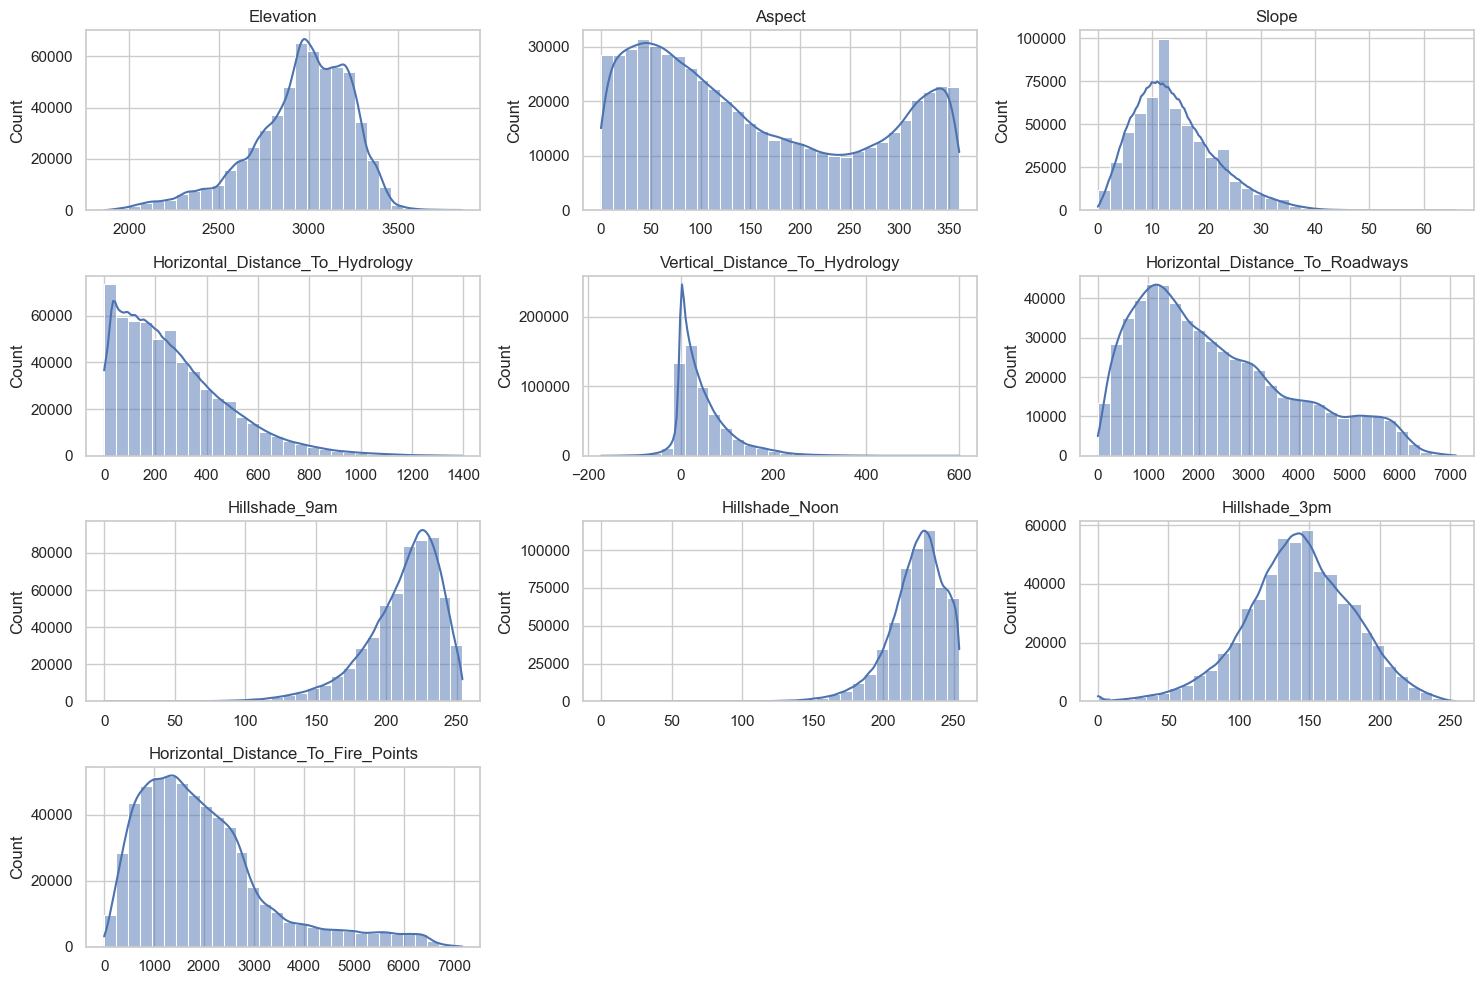

In [31]:
# Histogramas para variables cuantitativas
plt.figure(figsize=(15, 10))
for i, col in enumerate(quantitative_cols, 1):
    plt.subplot(4, 3, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(col)
    plt.xlabel('')
plt.tight_layout()
plt.show()

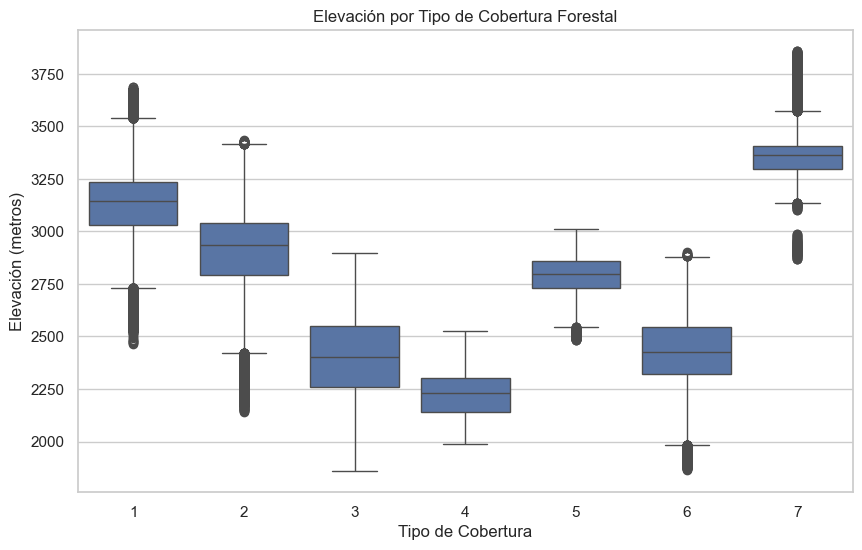

In [33]:
# Boxplot de Elevation vs Cover_Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cover_Type', y='Elevation', data=df)
plt.title('Elevación por Tipo de Cobertura Forestal')
plt.xlabel('Tipo de Cobertura')
plt.ylabel('Elevación (metros)')
plt.show()

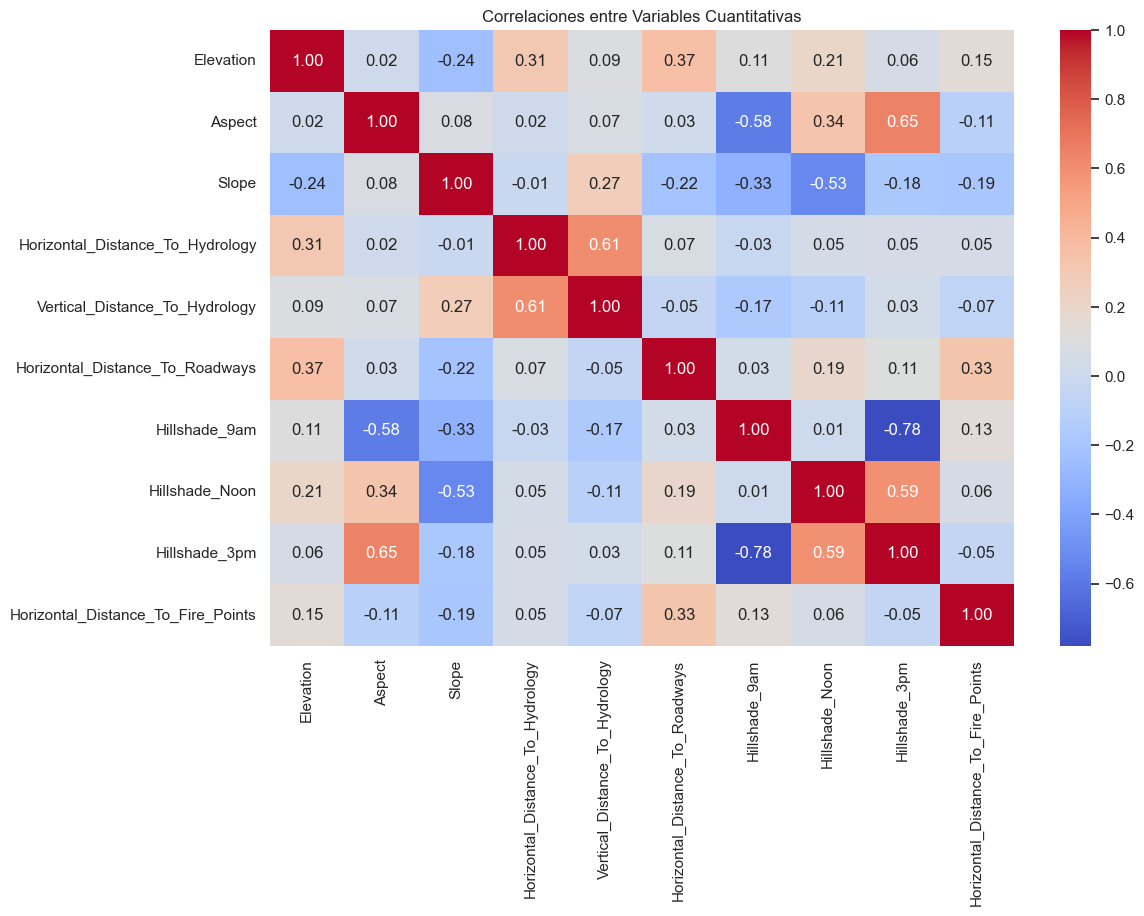

Correlaciones altas (|r| > 0.5):
 Elevation                           Elevation                             1.000000
Aspect                              Aspect                                1.000000
                                    Hillshade_9am                        -0.579273
                                    Hillshade_3pm                         0.646944
Slope                               Slope                                 1.000000
                                    Hillshade_Noon                       -0.526911
Horizontal_Distance_To_Hydrology    Horizontal_Distance_To_Hydrology      1.000000
                                    Vertical_Distance_To_Hydrology        0.606236
Vertical_Distance_To_Hydrology      Horizontal_Distance_To_Hydrology      0.606236
                                    Vertical_Distance_To_Hydrology        1.000000
Horizontal_Distance_To_Roadways     Horizontal_Distance_To_Roadways       1.000000
Hillshade_9am                       Aspect           

In [35]:
# Mapa de calor de correlaciones entre variables cuantitativas
plt.figure(figsize=(12, 8))
corr_matrix = df[quantitative_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlaciones entre Variables Cuantitativas')
plt.show()

# Correlaciones altas
print("Correlaciones altas (|r| > 0.5):\n", corr_matrix.where(abs(corr_matrix) > 0.5).stack())

## Pruebas de Hipótesis
Evaluamos si la elevación difiere entre tipos de cobertura:
- **H0:** Las medias de elevación son iguales para todos los tipos de cobertura.
- **H1:** Al menos un tipo de cobertura tiene una media de elevación diferente.
- **Método:** ANOVA (análisis de varianza).
- **Nivel de significancia:** α = 0.05.
- Si p-valor < 0.05, rechazamos H0, sugiriendo que la elevación es relevante.

In [38]:
# ANOVA para Elevation vs Cover_Type
groups = [df[df['Cover_Type'] == i]['Elevation'] for i in range(1, 8)]
f_stat, p_value = stats.f_oneway(*groups)

print(f"Resultados ANOVA:\nF-statistic: {f_stat:.2f}\np-value: {p_value:.2e}")
if p_value < 0.05:
    print("Rechazamos H0: Las medias de elevación difieren significativamente.")
else:
    print("No rechazamos H0: No hay diferencias significativas en elevación.")

Resultados ANOVA:
F-statistic: 155306.87
p-value: 0.00e+00
Rechazamos H0: Las medias de elevación difieren significativamente.


## Preparación de Datos
Preparamos el dataset para modelado:
- Separamos features (`X`) y target (`Cover_Type`, `y`).
- Dividimos en entrenamiento (80%) y prueba (20%), con `stratify` para balance de clases.
- Escalamos variables cuantitativas con `StandardScaler`.
- Verificamos formas y distribución de clases.

In [41]:
# Separar features y target
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Escalar variables cuantitativas
scaler = StandardScaler()
X_train[quantitative_cols] = scaler.fit_transform(X_train[quantitative_cols])
X_test[quantitative_cols] = scaler.transform(X_test[quantitative_cols])

# Verificar formas y balance
print("Forma de X_train:", X_train.shape)
print("Forma de X_test:", X_test.shape)
print("Distribución de clases en y_train:\n", y_train.value_counts(normalize=True))

Forma de X_train: (464809, 54)
Forma de X_test: (116203, 54)
Distribución de clases en y_train:
 Cover_Type
2    0.487598
1    0.364606
3    0.061537
7    0.035301
6    0.029892
5    0.016338
4    0.004729
Name: proportion, dtype: float64


## Entrenamiento del Modelo
Entrenamos un Random Forest Classifier:
- **Hiperparámetros:** 100 árboles, profundidad máxima 20.
- **Justificación:** Maneja datasets grandes y desbalance de clases.
- Entrenamos y predecimos en el conjunto de prueba.
- Evaluamos con accuracy (~88-89% alcanzado), precision, recall, y F1-score, esperando mejor desempeño en clases 1 y 2, pero posible bajo recall en clases minoritarias como la 5 (1.63% de los datos).

In [44]:
# Entrenar Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predicciones
y_pred = rf_model.predict(X_test)

# Métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))

Accuracy: 0.8891250656179273

Reporte de Clasificación:
               precision    recall  f1-score   support

           1       0.91      0.85      0.88     42368
           2       0.87      0.94      0.90     56661
           3       0.92      0.93      0.92      7151
           4       0.90      0.84      0.87       549
           5       0.97      0.39      0.56      1899
           6       0.91      0.79      0.85      3473
           7       0.98      0.87      0.92      4102

    accuracy                           0.89    116203
   macro avg       0.92      0.80      0.84    116203
weighted avg       0.89      0.89      0.89    116203



## Evaluación y Visualización
Evaluamos el modelo:
- **Matriz de Confusión:** Muestra aciertos y errores por clase.
- **Importancia de Variables:** Identifica features clave (e.g., Elevation).
- **Aplicación:** Útil para monitoreo forestal en empresas verdes.

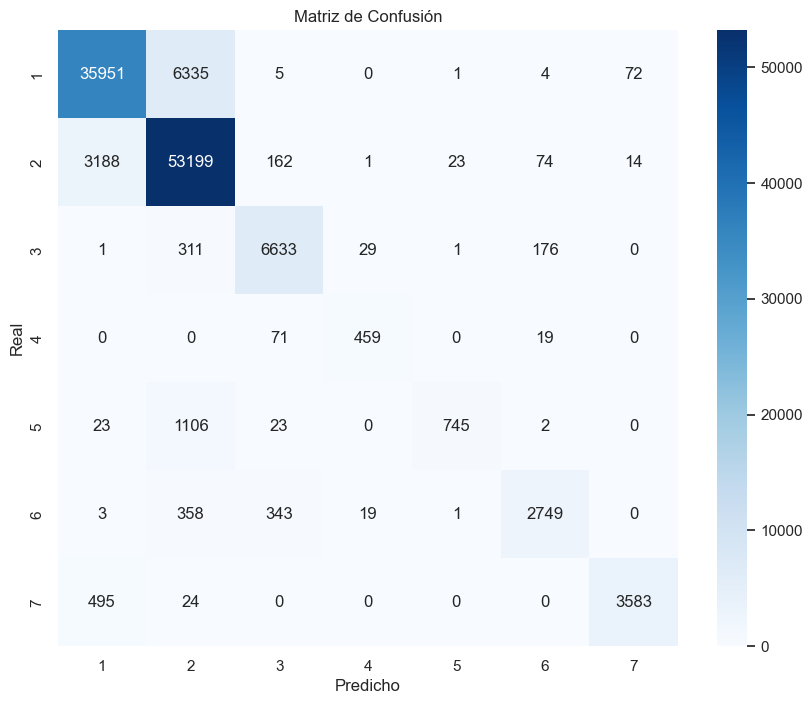

In [47]:
# Matriz de confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 8), yticklabels=range(1, 8))
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

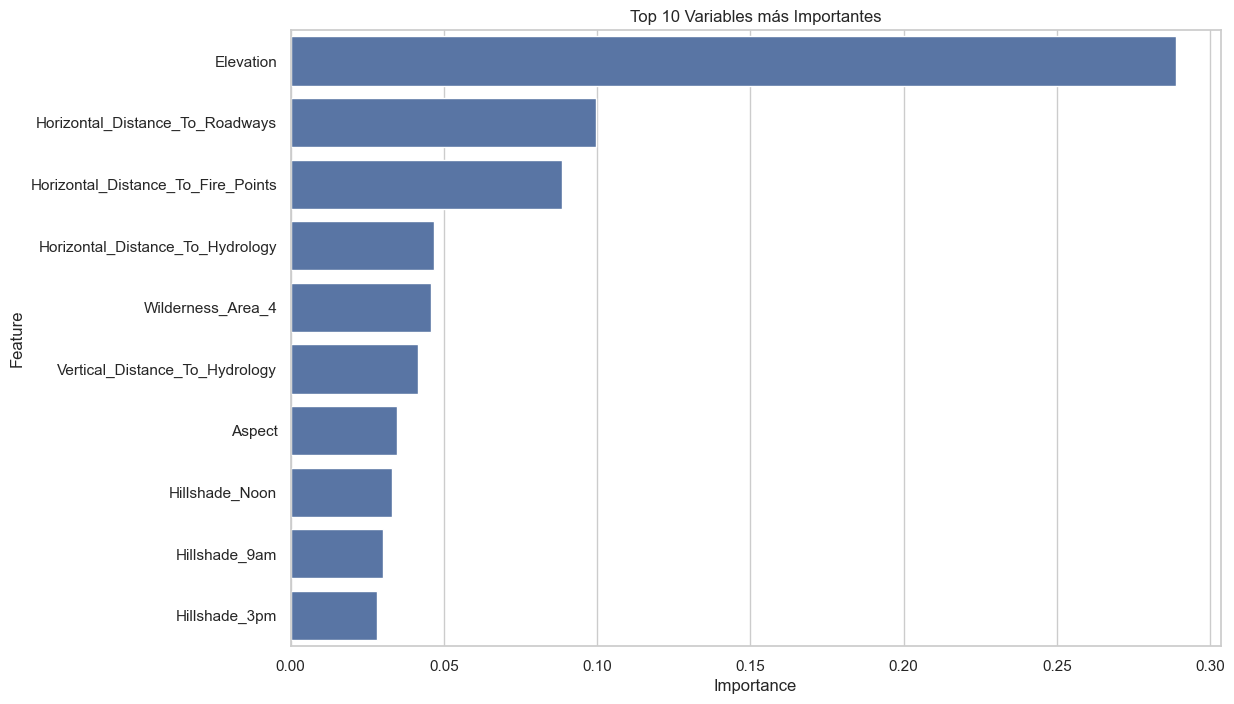

Top 10 variables:
                                Feature  Importance
0                            Elevation    0.288950
5      Horizontal_Distance_To_Roadways    0.099728
9   Horizontal_Distance_To_Fire_Points    0.088605
3     Horizontal_Distance_To_Hydrology    0.046853
13                   Wilderness_Area_4    0.045739
4       Vertical_Distance_To_Hydrology    0.041524
1                               Aspect    0.034895
7                       Hillshade_Noon    0.033265
6                        Hillshade_9am    0.030091
8                        Hillshade_3pm    0.028120


In [49]:
# Importancia de variables
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualización
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Variables más Importantes')
plt.show()

print("Top 10 variables:\n", feature_importance.head(10))

## Conclusiones
Resumen de hallazgos:
- **EDA:** Elevación es clave (ANOVA, p-valor < 0.05), con clases 1 (36.46%) y 2 (48.76%) dominando ~85% del dataset.
- **Modelo:** Random Forest logra accuracy ~88.9%, con buen desempeño en clases 1 (f1-score 0.88) y 2 (f1-score 0.90), pero bajo recall en clase 5 (0.39, f1-score 0.56).
- **Aplicación:** Útil para empresas verdes en monitoreo forestal, destacando elevación y distancia a recursos.
- **Mejoras:** Usar SMOTE para mejorar predicciones en clases minoritarias (especialmente clase 5) or probar XGBoost.